### Introduction

In colliders the two beams travel in opposite directions: assuming that the s-coordinate indicates the beam direction, it would be natural to define two different frames for the two beams.

On one hand, this is indeed needed for non periodic studies (like betatronic oscillations, betatronic mismatch, to localize losses, and, more in general tracking studies).

On the other hand, for the periodic optical solutions is practical to solve the TWISS problem for the two beams in the "same reference convention", e.g., clockwise convention.

E.g., in the LHC we need to define two beam sequences (one for beam 1, LHC B1, and the other for beam 2, LHC B2): starting the sequences from Interaction Point 1, IP1, (s=0 in IP1) is practical to define that the $s$ of IP1 is smaller than the $s$ of the other IPs for both sequences (clockwise convention). This means that the beam is traveling clockwise (in reality this is the case of LHC B1, but clearly not the case of LHC B2). The advantage of this approach is three-fold:

1. The two beams share several sections of the sequence: the approach of having the B2 in the clockwise convention simplifies the description of the shared sequences.
2. To compute the beam-beam interaction geometry, we need to express the beams in the same reference, anyhow.
3. For the periodic linear optics solution (CO, betas, tune, chromas...) is "irrelevant" the real direction of the B2, provided that the "correct flags" are set.

In the following examples, we would like to clarify and discuss about the "correct flags".

Before doing that, here you are some vocabulary and information.

In LHC we have two real-tracking sequences (B1 clockwise, LHC B1, B2 anti-clockwise, LHC B2). For the previous argument, we end up with 4 MAD-X sequences

- MADX B1 in a clockwise sequence       => in lhc_as_built sequence file and named lhcb1. This is a real-tracking sequence. We can refer to it as LHC B1 sequence.
- MADX B2 in a clockwise sequence       => in lhc_as_built sequence file and named lhcb2.
- MADX B3 in an anti-clockwise sequence => not available at the moment.
- MADX B4 in an anti-clockwise sequence => in lhcb4_as_built sequence file and named lhcb2. This is a real-tracking sequence. We can refer to it as LHC B2 sequence.

In the case of LHC, B1 and B2 have the same momentum and positive charge.

In the following examples we will start from a single sequence called "collider_clockwise" and we will test it with different beams.

We will consider a single periodic cell with dipoles, quadrupoles and sextuples in thin approximation exploring different beam versus flag (bv) and beam charges. 

Then we will guide the reader in the construction of the "collider anti-clockwise" sequence starting from the "collider clockwise".

We will comment about the survey and twiss results.

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from cpymad.madx import Madx
import pandas as pd
from madxp import cpymadTool as mt

We use a simple function to define the input string of MADX. We consider as parameter the beam versus, **bv**, and the particle species, **particle**.

Please note the use of the **clockwise_direction** knob: it will be crucial for the building of the anti-clockwise sequence.
The rationale is that by changing the s-direction, the x-direction of the reference systems has to change too if maintaining the y-direction unchanged (right-hand oriented reference system).
In doing so the the EM field components along $x$ and $s$ (and all derivatives in $x$, $s$ have to be reconsidered).
For the **thin multipole** element the normal and skew components are 

$K_{\mathrm{N}, n} L=\frac{L}{B \rho} \frac{\partial^{n} B_{y}}{\partial x^{n}} ; \quad$ and $\quad K_{\mathrm{S}, n} L=\frac{L}{B \rho} \frac{\partial^{n} B_{x}}{\partial x^{n}}$ 

therefore when changing the $s$-direction, the sign of the single components should be reconsidered (e.g., for $K_{\mathrm{N}, n} L$ the odd $n$ components do change sign while for $K_{\mathrm{S}, n} L$ the even $n$ components do change sign). Similar arguments hold also for optics phases advances, $\alpha$-functions, RF phases...

We assume a regular lattice with a single FODO cell, 100 m long and with 4 dipoles. We introduce also sextupoles and octupoles. Their values are arbitrary and are intended only for the sake simplicity and completeness. The reader can tune the parameters to obtain a lattice closer to a real one. Despite the fact that the proposed thin lattice is far from being represenative of a realistic collider, it is suitable to introduce the contents that follow.

In [3]:
def make_string(bv=1, particle='proton'):
    return f'''
    !! general parameters
    lcell = 100;
    nbend=4;

    !! dipole parameters
    ld = 15;
    clockwise_direction=1;
    ad = 2*pi/nbend;

    !! quadrupole parameters
    k1f = 5e-3;
    k1d = -k1f;
    lq =5;

    !! sextupole parameters
    k2f = 0.01;
    k2d = -k2f;
    ls = 0.5;
    qf: multipole, knl:={{0, k1f*clockwise_direction*lq}};
    qd: multipole, knl:={{0, k1d*clockwise_direction*lq}};
    bm: multipole, knl:={{ad, 0}};
    sf: multipole, knl:={{0, 0, k2f*ls, .1*clockwise_direction}};
    sd: multipole, knl:={{0, 0, k2d*ls, -.1*clockwise_direction}};
    my_marker: marker;

    collider: sequence, l=100; 
    q1: qf, at=0+;
    sf, at=5;
    m1: my_marker, at=6;
    bm, at=10;
    bm, at=30;
    m2: my_marker, at=50-.9;
    qd, at=50;
    sd, at=55;
    m3: my_marker, at=56.4;
    bm, at=60;
    bm, at=80;
    m4: my_marker, at=100-1.5;
    endsequence;

    beam, particle={particle}, energy=7000, bv={bv}, sequence=collider;
    use, sequence=collider;
    survey, table='survey';
    twiss, table='thin';
    twiss, table=off_momentum_detuning, deltap=-0.001:0.0011:0.0001;
'''

The we can run 4 instances of MADX, by exploring 4 combinations of **bv** and **particle**.

In [ ]:
madx_b1_proton = Madx()
madx_b1_proton.input(make_string(bv=1, particle='proton'))
madx_b2_proton = Madx()
madx_b2_proton.input(make_string(bv=-1, particle='proton'))
madx_b1_antiproton = Madx()
madx_b1_antiproton.input(make_string(bv=1, particle='antiproton'))
madx_b2_antiproton = Madx()
madx_b2_antiproton.input(make_string(bv=-1, particle='antiproton'))

### Survey
From the survey one can see, as expected, that even the description of the machine is the same for B1 and B2, in reality the two machines have to be different (since the survey is different).

To be noted that even the survey is the same, given a certain beam versus, for proton and anti-proton, this is just because the gradient are normalised to the momentum (and therefore the information of beam energy, A and Z number are taken into account in the normalization).

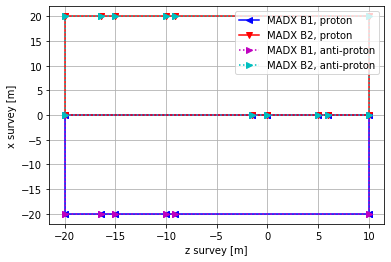

In [5]:
plt.figure()
for mad, my_label, my_format in zip([madx_b1_proton, madx_b2_proton, madx_b1_antiproton, madx_b2_antiproton],
['MADX B1, proton','MADX B2, proton','MADX B1, anti-proton','MADX B2, anti-proton'],
['<-b','v-r','>:m','>:c']):
    aux=mt.twiss_df(mad.table.survey)
    plt.plot(aux['z'],aux['x'],my_format, label=my_label)
plt.legend(loc='best')
plt.xlabel('z survey [m]')
plt.ylabel('x survey [m]')
plt.grid(True)

### Beta-functions

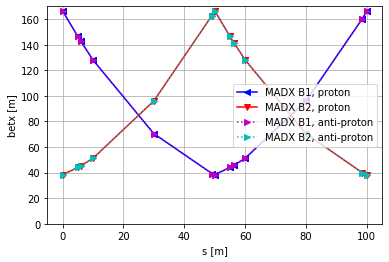

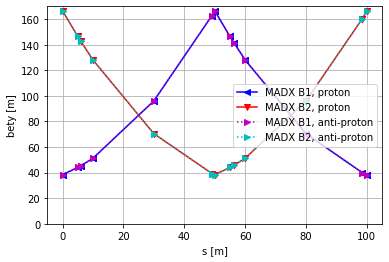

In [6]:
# betx thin
plt.figure()
for mad, my_label, my_format in zip([madx_b1_proton, madx_b2_proton, madx_b1_antiproton, madx_b2_antiproton],
['MADX B1, proton','MADX B2, proton','MADX B1, anti-proton','MADX B2, anti-proton'],
['<-b','v-r','>:m','>:c']):
    aux=mt.twiss_df(mad.table.thin)
    plt.plot(aux['s'], aux['betx'],my_format, label=my_label)
plt.legend(loc='best')
plt.xlabel('s [m]')
plt.ylabel('betx [m]')
plt.grid(True)
plt.ylim([0,170]);
# bety thin
plt.figure()
for mad, my_label, my_format in zip([madx_b1_proton, madx_b2_proton, madx_b1_antiproton, madx_b2_antiproton],
['MADX B1, proton','MADX B2, proton','MADX B1, anti-proton','MADX B2, anti-proton'],
['<-b','v-r','>:m','>:c']):
    aux=mt.twiss_df(mad.table.thin)
    plt.plot(aux['s'], aux['bety'],my_format, label=my_label)
plt.legend(loc='best')
plt.xlabel('s [m]')
plt.ylabel('bety [m]')
plt.grid(True)
plt.ylim([0,170]);

### Tune vs off-momentum

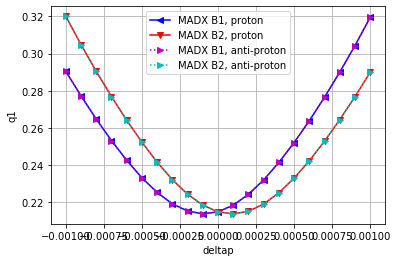

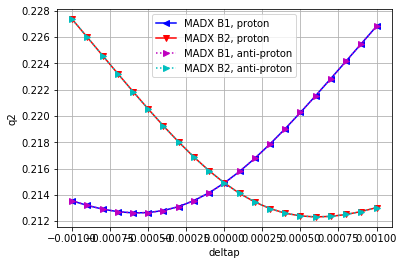

In [7]:
for tune in ['q1','q2']:
    plt.figure()
    for mad, my_label, my_format in zip([madx_b1_proton, madx_b2_proton, madx_b1_antiproton, madx_b2_antiproton],
    ['MADX B1, proton','MADX B2, proton','MADX B1, anti-proton','MADX B2, anti-proton'],
    ['<-b','v-r','>:m','>:c']):
        aux=pd.DataFrame(dict(mad.table.summ))
        plt.plot(aux['deltap'], aux[tune], my_format, label=my_label)
    plt.legend(loc='best')
    plt.xlabel('deltap')
    plt.ylabel(tune)
    plt.grid(True)

### From clockwise to anti-clockwise sequence
This function will create another string to add to the first one.

There are 3 steps:

- reflect the sequence
- change the **clockwise_direction** knob
- redefine the beam conveniently.

In [8]:
def make_string_reflection(bv=1, particle='proton'):
    return f'''\n
    seqedit, sequence=collider;
    flatten;
    reflect;
    flatten;
    endedit;
    clockwise_direction=-1;
    beam, particle={particle}, energy=7000, bv={bv}, sequence=collider;
    use, sequence=collider;
    twiss, table=thin;
    twiss, table=off_momentum_detuning, deltap=-0.001:0.0011:0.0001;
    '''


We therefore build the b3 and b4 sequences.

In [ ]:
madx_b3_proton = Madx()
madx_b3_proton.input(make_string(bv=1, particle='proton')+make_string_reflection(bv=-1, particle='proton'))
madx_b4_proton = Madx()
madx_b4_proton.input(make_string(bv=-1, particle='proton')+make_string_reflection(bv=1, particle='proton'))
madx_b3_antiproton = Madx()
madx_b3_antiproton.input(make_string(bv=1, particle='antiproton')+make_string_reflection(bv=-1, particle='antiproton'))
madx_b4_antiproton = Madx()
madx_b4_antiproton.input(make_string(bv=-1, particle='antiproton')+make_string_reflection(bv=1, particle='antiproton'))

### Sanity checks
By plotting the marker tables one can see that the B1/B3 and B2/B4 s-order is inverted but comparing the same marker (e.g., **m1:1** in B1 and B3) the $\beta$-functions are the same as expected (the $\alpha$ functions are inverter since is proportional to the first order derivative in $s$ of $\beta(s)$. The phase advance of internal points are opposite.

In [13]:
for mad in [madx_b1_proton, madx_b3_proton, madx_b2_proton, madx_b4_proton]:
    aux=pd.DataFrame(dict(mad.table.thin))
    print('\n')
    display(aux[aux['keyword']=='marker'][['name','s','betx','alfx','mux','bety','alfy','muy']])

name      s        betx      alfx       mux        bety  \
0   collider$start:1    0.0  166.533280 -2.081666  0.000000   38.430757   
5               m1:1    6.0  142.706211  1.889512  0.006196   45.348293   
11              m2:1   49.1   39.321390  0.509208  0.103765  162.812222   
17              m3:1   56.4   45.891448 -0.685348  0.131800  141.199725   
23              m4:1   98.5  160.360340 -2.033628  0.213440   39.943968   
25    collider$end:1  100.0  166.533280 -2.081666  0.214901   38.430757   

        alfy       muy  
0   0.480384  0.000000  
5  -0.672538  0.022954  
11 -2.052843  0.106581  
17  1.876702  0.114095  
23  0.528423  0.208806  
25  0.480384  0.214901

name      s        betx      alfx       mux        bety  \
0     collider$end:1    0.0  166.533280  2.081666  0.000000   38.430757   
2               m4:1    1.5  160.360340  2.033628  0.001461   39.943968   
8               m3:1   43.6   45.891448  0.685348  0.083101  141.199725   
14              m2:1   50.9   39.321390 -0.509208  0.111136  162.812222   
20              m1:1   94.0  142.706211 -1.889512  0.208705   45.348293   
25  collider$start:1  100.0  166.533280  2.081666  0.214901   38.430757   

        alfy       muy  
0  -0.480384  0.000000  
2  -0.528423  0.006095  
8  -1.876702  0.100806  
14  2.052843  0.108320  
20  0.672538  0.191947  
25 -0.480384  0.214901

name      s        betx      alfx       mux        bety  \
0   collider$start:1    0.0   38.430757  0.480384  0.000000  166.533280   
5               m1:1    6.0   45.348293 -0.672538  0.022954  142.706211   
11              m2:1   49.1  162.812222 -2.052843  0.106581   39.321390   
17              m3:1   56.4  141.199725  1.876702  0.114095   45.891448   
23              m4:1   98.5   39.943968  0.528423  0.208806  160.360340   
25    collider$end:1  100.0   38.430757  0.480384  0.214901  166.533280   

        alfy       muy  
0  -2.081666  0.000000  
5   1.889512  0.006196  
11  0.509208  0.103765  
17 -0.685348  0.131800  
23 -2.033628  0.213440  
25 -2.081666  0.214901

name      s        betx      alfx       mux        bety  \
0     collider$end:1    0.0   38.430757 -0.480384  0.000000  166.533280   
2               m4:1    1.5   39.943968 -0.528423  0.006095  160.360340   
8               m3:1   43.6  141.199725 -1.876702  0.100806   45.891448   
14              m2:1   50.9  162.812222  2.052843  0.108320   39.321390   
20              m1:1   94.0   45.348293  0.672538  0.191947  142.706211   
25  collider$start:1  100.0   38.430757 -0.480384  0.214901  166.533280   

        alfy       muy  
0   2.081666  0.000000  
2   2.033628  0.001461  
8   0.685348  0.083101  
14 -0.509208  0.111136  
20 -1.889512  0.208705  
25  2.081666  0.214901

The table above would be conclusive for our scope. We complete it with the following plots about the survey, twiss and off-momentum tunes.

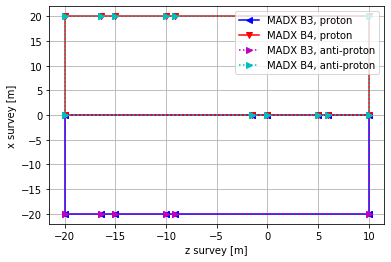

In [11]:
# Survey
plt.figure()
for mad, my_label, my_format in zip([madx_b3_proton, madx_b4_proton, madx_b3_antiproton, madx_b4_antiproton],
['MADX B3, proton','MADX B4, proton','MADX B3, anti-proton','MADX B4, anti-proton'],
['<-b','v-r','>:m','>:c']):
    aux=mt.twiss_df(mad.table.survey)
    plt.plot(aux['z'],aux['x'],my_format, label=my_label)
plt.legend(loc='best')
plt.xlabel('z survey [m]')
plt.ylabel('x survey [m]')
plt.grid(True)

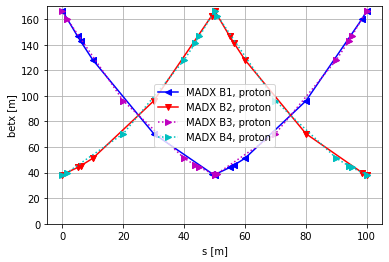

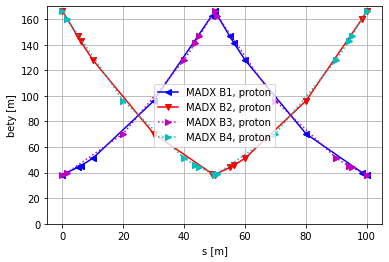

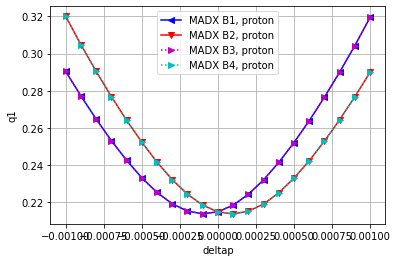

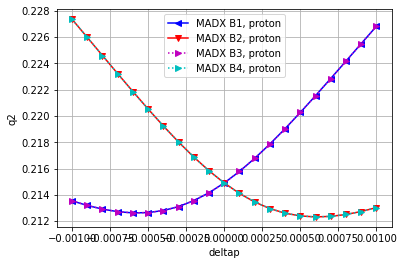

In [12]:
# betx 
plt.figure()
for mad, my_label, my_format in zip([madx_b1_proton, madx_b2_proton, madx_b3_proton, madx_b4_proton],
['MADX B1, proton','MADX B2, proton','MADX B3, proton','MADX B4, proton'],
['<-b','v-r','>:m','>:c']):
    aux=mt.twiss_df(mad.table.thin)
    plt.plot(aux['s'], aux['betx'],my_format, label=my_label)
plt.legend(loc='best')
plt.xlabel('s [m]')
plt.ylabel('betx [m]')
plt.grid(True)
plt.ylim([0,170]);

# betx 
plt.figure()
for mad, my_label, my_format in zip([madx_b1_proton, madx_b2_proton, madx_b3_proton, madx_b4_proton],
['MADX B1, proton','MADX B2, proton','MADX B3, proton','MADX B4, proton'],
['<-b','v-r','>:m','>:c']):
    aux=mt.twiss_df(mad.table.thin)
    plt.plot(aux['s'], aux['bety'],my_format, label=my_label)
plt.legend(loc='best')
plt.xlabel('s [m]')
plt.ylabel('bety [m]')
plt.grid(True)
plt.ylim([0,170]);

# off-momentum tune
for tune in ['q1','q2']:
    plt.figure()
    for mad, my_label, my_format in zip([madx_b1_proton, madx_b2_proton, madx_b3_proton, madx_b4_proton],
['MADX B1, proton','MADX B2, proton','MADX B3, proton','MADX B4, proton'],
['<-b','v-r','>:m','>:c']):
        aux=pd.DataFrame(dict(mad.table.summ))
        plt.plot(aux['deltap'], aux[tune], my_format, label=my_label)
    plt.legend(loc='best')
    plt.xlabel('deltap')
    plt.ylabel(tune)
    plt.grid(True)

### Conclusions

As accelerator physicists, we can work, namely for LHC studies, with useful abstractions as MADX B3 and B4. We prepared this document for presenting a simple step-by-step approach in a minimal example, with particular attention in the progression of the concepts.

Beyond this documentation exercise, we think that, introducing a **clockwise_direction** knob in the definition of the strength of MADX elements, would be a relatively simple but beneficial trick to build, on-the-fly, an anti-clockwise sequence from a clockwise one.